In [17]:
from __future__ import absolute_import, division, print_function, unicode_literals
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from tensorflow import keras

#import DataGenerator as DG
from DataGenerator import DataGenerator

import sklearn.metrics as metrics

import numpy as np
import random
import math
import os
import glob

import matplotlib.pyplot as plt

import h5py

In [18]:
###FIX NUMPY LOAD FOR DICTIONARIES
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [19]:
depth = 10

In [20]:
model_files=["model-2019-07-26-20:21:18.h5",
"model-2019-07-26-20:25:44.h5",
"model-2019-07-26-20:36:01.h5",
"model-2019-07-26-20:39:22.h5"]
use_single = True
single_model = "model-2019-07-31-10:58:45.h5"
#"model-2019-07-24-19:30:14.h5",
filepath = "images_synthetic_mouse.h5"

scratch_dir = ""#"/n/scratch2/ap487/"
if not os.path.exists((scratch_dir+filepath)):
    copy(filepath,scratch_dir)
    print("File Copied to scratch directory")
filepath=scratch_dir+filepath
print("Using path: ",filepath)

Using path:  images_synthetic_mouse.h5


In [5]:
def accuracy(predictions, answers, top_n=5):
    accs = np.zeros(len(answers))
    predicts = np.zeros(len(test_labels))
    for i in range(0,len(answers)):
        j = len(predictions[i])-1
        for k in range(0,top_n):
            if predictions[i][j-k]==answers[i]:
                accs[i]=1
                predicts[i]=predictions[i][j-k]
    return np.mean(accs), predicts

In [22]:
with h5py.File(filepath,'r') as f:
    amt = 30000
    print("Test Data Length:" , amt)
    if depth == 1:
        test_data=np.zeros((amt,80,80,1))
    else:
        test_data=np.zeros((amt,depth,80,80,1))
    print(test_data.shape)
    test_labels=np.zeros(amt)
    #Starting index for batch samples
    index = 0
    data_gen = DataGenerator(filepath,data_amount=amt*depth,batch_size=amt,frames_per_sample=depth,offset=0,sliding_window=True)
    dat,lbl = data_gen.__getitem__(0)
    test_data=dat
    test_labels=lbl
    print(test_data.shape)

Test Data Length: 30000
(30000, 10, 80, 80, 1)
(30000, 10, 80, 80, 1)


In [23]:
models = []
if use_single:
    models.append(keras.models.load_model(single_model))
else:
    for i in range(0, len(model_files)):
        models.append(keras.models.load_model(model_files[i]))

In [24]:
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
    # make predictions
    yhats = [model.predict(testX,verbose=1) for model in members]
    yhats = np.array(yhats)
    # sum across ensemble members
    summed = np.sum(yhats, axis=0)
    # argmax across classes
    result = np.argmax(summed, axis=1)
    return result

30000/30000 [==============================] - 28s 939us/sample
0.027033333333333333


/home/g17amitprasad_gmail_com/miniconda3/envs/tf2_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


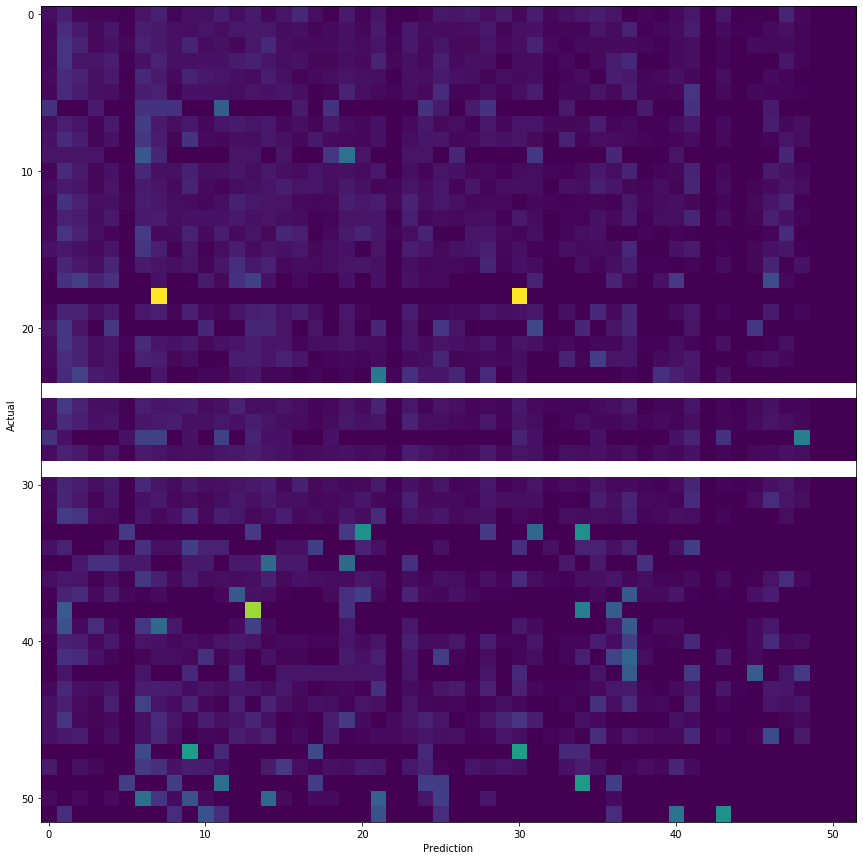

In [25]:
#yhats = [model.predict(test_data,verbose=1) for model in models]
#print(yhats[0][0])
p=ensemble_predictions(models,test_data)
s = 0
for i in range(0,len(p)):
    if p[i]==test_labels[i]:
        s+=1
print(s/len(p))
conf_mat=metrics.confusion_matrix(test_labels,p)
conf_mat=conf_mat / conf_mat.astype(np.float).sum(axis=1,keepdims=True)
plt.rcParams["figure.figsize"] = (15,15)
plt.imshow(conf_mat)
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [26]:
#model_benchmarks = np.load("benchmarks.npy")
#model_benchmarks.item()[name]=metrics.f1_score(test_labels,predicts,average=None)
#np.save("benchmarks.npy",model_benchmarks)
np.save("2DplusLSTM2Sliding_F1.npy",metrics.f1_score(test_labels,p,average=None))

/home/g17amitprasad_gmail_com/miniconda3/envs/tf2_gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/g17amitprasad_gmail_com/miniconda3/envs/tf2_gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


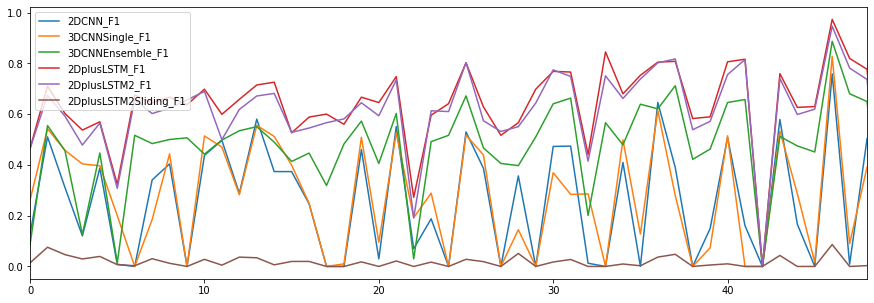

In [27]:
f1_paths = glob.glob("*.npy")
plt.rcParams["figure.figsize"] = (15,5)
for path in f1_paths:
    plt.plot(np.load(path),label=path.split('.')[0])
plt.xlim(0,48)
plt.legend()
plt.show()

In [19]:
print(metrics.f1_score(test_labels,p,average=None))

[0.46389497 0.6736429  0.5920904  0.4781491  0.56449553 0.30769231
 0.65668849 0.60219342 0.62371889 0.6558089  0.68916519 0.49916805
 0.61849711 0.67125984 0.68148148 0.52816901 0.5451448  0.56613757
 0.58103976 0.64467005 0.59340659 0.73461538 0.19117647 0.61304348
 0.61006289 0.80330579 0.57377049 0.53144016 0.55059253 0.64359862
 0.77435897 0.74834437 0.41463415 0.75078864 0.6614786  0.73786408
 0.80217786 0.81717011 0.53846154 0.57142857 0.75555556 0.81508516
 0.         0.74050633 0.5984252  0.61956522 0.94612352 0.78129713
 0.73652695 0.         0.         0.         0.        ]


In [22]:
print(np.load("2DplusLSTM2Sliding_F1.npy"))

[0.01436782 0.07556193 0.04655327 0.02946955 0.03941385 0.00705467
 0.00280702 0.03042254 0.01244344 0.         0.02801462 0.00512383
 0.03666245 0.03424879 0.00628437 0.01973094 0.01975684 0.
 0.         0.01796407 0.         0.02148997 0.         0.01706161
 0.         0.02816901 0.01892473 0.         0.05113636 0.
 0.01748385 0.02754237 0.         0.         0.00963855 0.00272109
 0.03679369 0.04781533 0.         0.0056338  0.01031688 0.
 0.         0.04327666 0.         0.         0.08626198 0.
 0.00324675 0.         0.         0.        ]


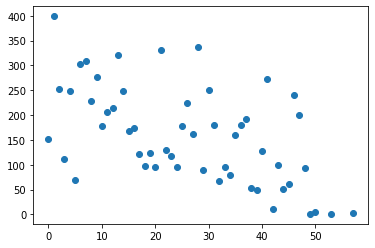

In [25]:
u=np.unique(test_labels,return_counts=True)
plt.scatter(u[0],u[1])
plt.show()

In [15]:
!nvidia-smi 

Wed Jul 31 17:35:22 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    32W / 250W |  15727MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  